Our approach involves starting with a pretrained DETR model and fine-tuning it on a custom dataset of annotated fashion images, namely Fashionpedia. By doing so, we’ll adapt the model to better recognize and detect objects within the fashion domain.

deploy it as a Gradio Space on Hugging Face. Additionally, we’ll explore how to interact with the deployed model using the Gradio API, enabling seamless communication with the hosted Space and unlocking new possibilities for real-world applications.

In [10]:
!pip install -U -q datasets timm wandb torchmetrics peft tranformers jinja2
# Tested with datasets==2.21.0, transformers==4.44.2 timm==1.0.9, wandb==0.17.9 torchmetrics==1.4.1

ERROR: Could not find a version that satisfies the requirement tranformers (from versions: none)
ERROR: No matching distribution found for tranformers


In [11]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write)

In [3]:
from datasets import load_dataset

dataset = load_dataset("detection-datasets/fashionpedia")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)-00000-of-00007-fe108070118553c3.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00001-of-00007-f41a5a9c38c9005b.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00002-of-00007-40bc8456894bcbcd.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00003-of-00007-9a99ff8dc572e02c.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00004-of-00007-f4e6f12cd2cedfea.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00005-of-00007-41d8dfe1edb6591e.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00006-of-00007-f41b0f2f4bbefac9.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00000-of-00001-0b29e85429788213.parquet:   0%|          | 0.00/84.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45623 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1158 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 45623
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1158
    })
})

In [4]:
dataset["train"][0]

{'image_id': 23,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=682x1024>,
 'width': 682,
 'height': 1024,
 'objects': {'bbox_id': [150311, 150312, 150313, 150314],
  'category': [23, 23, 33, 10],
  'bbox': [[445.0, 910.0, 505.0, 983.0],
   [239.0, 940.0, 284.0, 994.0],
   [298.0, 282.0, 386.0, 352.0],
   [210.0, 282.0, 448.0, 665.0]],
  'area': [1422, 843, 373, 56375]}}

In [5]:
train_dataset = dataset["train"]
test_dataset = dataset["val"]

In [6]:
# subsample to speedup training
def create_sample(dataset, sample_fraction=0.01, seed=42):
    sample_size = int(sample_fraction * len(dataset))
    sampled_dataset = dataset.shuffle(seed=seed).select(range(sample_size))
    print(f"Original size: {len(dataset)}")
    print(f"Sample size: {len(sampled_dataset)}")
    return sampled_dataset

train_dataset = create_sample(train_dataset)
test_dataset = create_sample(test_dataset)

Original size: 45623
Sample size: 456
Original size: 1158
Sample size: 11


In [7]:
import numpy as np
from PIL import Image, ImageDraw

id2label = {
    0: "shirt, blouse",
    1: "top, t-shirt, sweatshirt",
    2: "sweater",
    3: "cardigan",
    4: "jacket",
    5: "vest",
    6: "pants",
    7: "shorts",
    8: "skirt",
    9: "coat",
    10: "dress",
    11: "jumpsuit",
    12: "cape",
    13: "glasses",
    14: "hat",
    15: "headband, head covering, hair accessory",
    16: "tie",
    17: "glove",
    18: "watch",
    19: "belt",
    20: "leg warmer",
    21: "tights, stockings",
    22: "sock",
    23: "shoe",
    24: "bag, wallet",
    25: "scarf",
    26: "umbrella",
    27: "hood",
    28: "collar",
    29: "lapel",
    30: "epaulette",
    31: "sleeve",
    32: "pocket",
    33: "neckline",
    34: "buckle",
    35: "zipper",
    36: "applique",
    37: "bead",
    38: "bow",
    39: "flower",
    40: "fringe",
    41: "ribbon",
    42: "rivet",
    43: "ruffle",
    44: "sequin",
    45: "tassel",
}

label2id = {v: k for k, v in id2label.items()}

{'bbox_id': [54243, 54244, 54245, 54246, 54247, 54248, 54249], 'category': [8, 32, 42, 42, 32, 42, 42], 'bbox': [[17.0, 190.0, 724.0, 809.0], [43.0, 323.0, 147.0, 528.0], [122.0, 328.0, 143.0, 349.0], [43.0, 506.0, 63.0, 528.0], [614.0, 327.0, 704.0, 541.0], [616.0, 329.0, 637.0, 349.0], [684.0, 514.0, 703.0, 537.0]], 'area': [390056, 10806, 329, 330, 10075, 300, 303]}


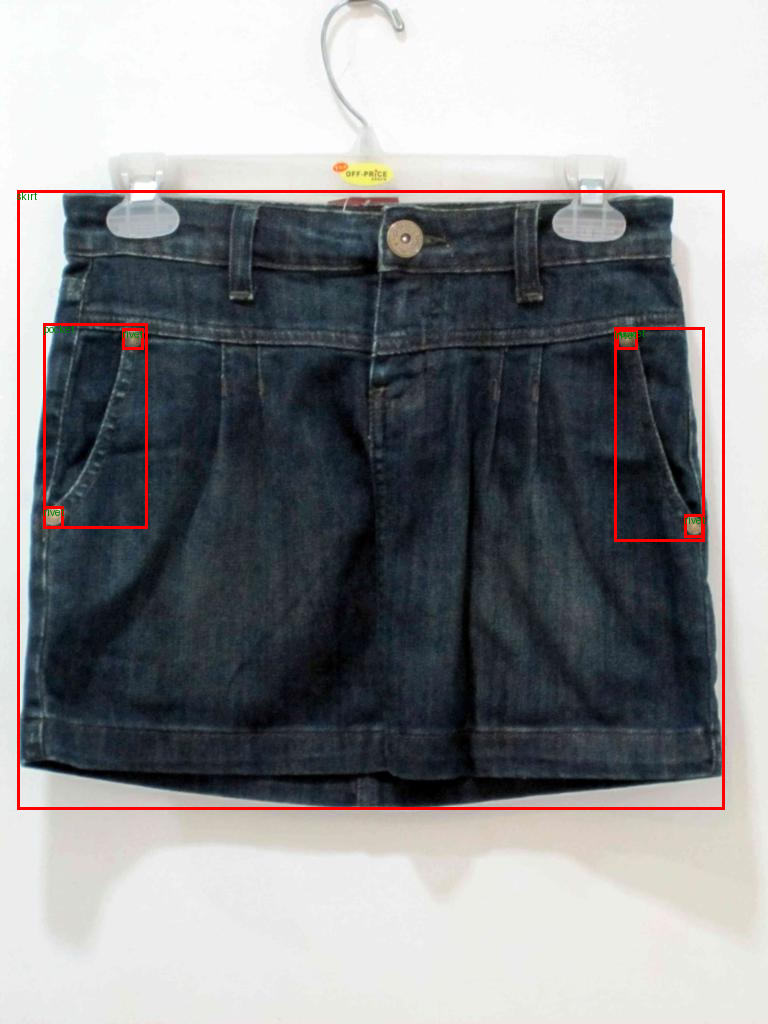

In [8]:
def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    print(annotations)
    for i in range(len(annotations["bbox_id"])):
        box = annotations["bbox"][i]
        x1, y1, x2, y2 = tuple(box)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        draw.text((x1, y1), id2label[annotations["category"][i]], fill="green")

    return image

draw_image_from_idx(dataset=train_dataset, idx=4)

{'bbox_id': [210791, 210792, 210793], 'category': [10, 33, 19], 'bbox': [[244.0, 376.0, 477.0, 1023.0], [320.0, 381.0, 411.0, 444.0], [298.0, 544.0, 477.0, 710.0]], 'area': [110382, 1094, 5484]}
{'bbox_id': [246547, 246548, 246549, 246550], 'category': [1, 33, 31, 31], 'bbox': [[1.0, 1.0, 705.0, 1018.0], [205.0, 1.0, 527.0, 64.0], [1.0, 34.0, 138.0, 992.0], [582.0, 34.0, 705.0, 987.0]], 'area': [563513, 4381, 89026, 89122]}
{'bbox_id': [61520, 61521, 61522, 61523], 'category': [2, 31, 33, 31], 'bbox': [[261.0, 107.0, 742.0, 953.0], [668.0, 149.0, 742.0, 855.0], [386.0, 107.0, 657.0, 261.0], [261.0, 143.0, 339.0, 839.0]], 'area': [331332, 31503, 10096, 30340]}
{'bbox_id': [81290, 81291, 81292, 81293, 81294, 81295], 'category': [9, 31, 31, 28, 32, 32], 'bbox': [[254.0, 120.0, 778.0, 957.0], [674.0, 250.0, 778.0, 775.0], [254.0, 239.0, 360.0, 775.0], [391.0, 120.0, 638.0, 239.0], [613.0, 594.0, 701.0, 805.0], [323.0, 597.0, 400.0, 800.0]], 'area': [322839, 30361, 31630, 10759, 15002, 1253

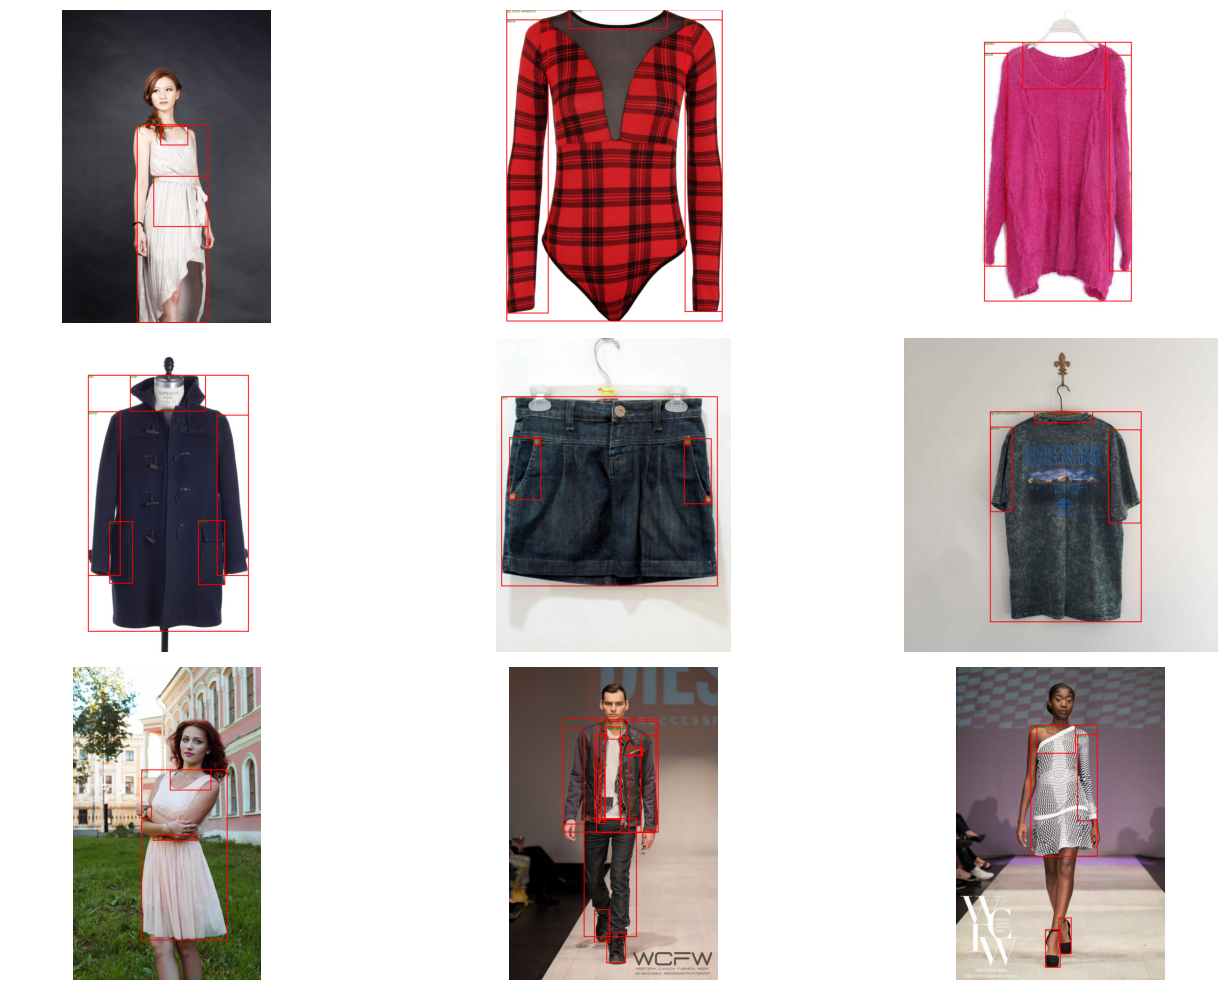

In [9]:
import matplotlib.pyplot as plt

def plot_images(dataset, indices):
    num_cols = 3
    num_rows = int(np.ceil(len(indices) / num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        image = draw_image_from_idx(dataset, idx)

        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()


plot_images(train_dataset, range(9))

## filter invalid bboxes



In [12]:
train_dataset[0]["objects"]["bbox"]

[[244.0, 376.0, 477.0, 1023.0],
 [320.0, 381.0, 411.0, 444.0],
 [298.0, 544.0, 477.0, 710.0]]

In [13]:
from datasets import Dataset

def filter_invalid_bboxes(example):
    valid_bboxes = []
    valid_bbox_ids = []
    valid_categories = []
    valid_areas = []

    for i, bbox in enumerate(example["objects"]["bbox"]):
        x_min, y_min, x_max, y_max = bbox[:4]
        if x_min < x_max and y_min < y_max:
            valid_bboxes.append(bbox)
            valid_bbox_ids.append(example["objects"]["bbox_id"][i])
            valid_categories.append(example["objects"]["category"][i])
            valid_areas.append(example["objects"]["area"][i])
        else:
            print(
                f"Image with invalid bbox: {example['image_id']} Invalid bbox detected and discarded: {bbox} - bbox_id: {example['objects']['bbox_id'][i]} - category: {example['objects']['category'][i]}"
            )

    example["objects"]["bbox"] = valid_bboxes
    example["objects"]["bbox_id"] = valid_bbox_ids
    example["objects"]["category"] = valid_categories
    example["objects"]["area"] = valid_areas

    return example

train_ds = train_dataset.map(filter_invalid_bboxes)
test_ds = test_dataset.map(filter_invalid_bboxes)

Map:   0%|          | 0/456 [00:00<?, ? examples/s]

Image with invalid bbox: 26549 Invalid bbox detected and discarded: [0.0, 0.0, 0.0, 0.0] - bbox_id: 311943 - category: 37


Map:   0%|          | 0/11 [00:00<?, ? examples/s]

In [14]:
print(train_ds)
print(test_ds)

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 456
})
Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 11
})


visualize class occurences

In [15]:
id_list = []
category_examples = {}
for example in train_dataset:
    id_list += example["objects"]["bbox_id"]
    for category in example["objects"]["category"]:
        if id2label[category] not in category_examples:
            category_examples[id2label[category]] = 1
        else:
            category_examples[id2label[category]] += 1

id_list.sort()

<ipython-input-16-ec0e47ed081b>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(categories, rotation=90, ha="right")


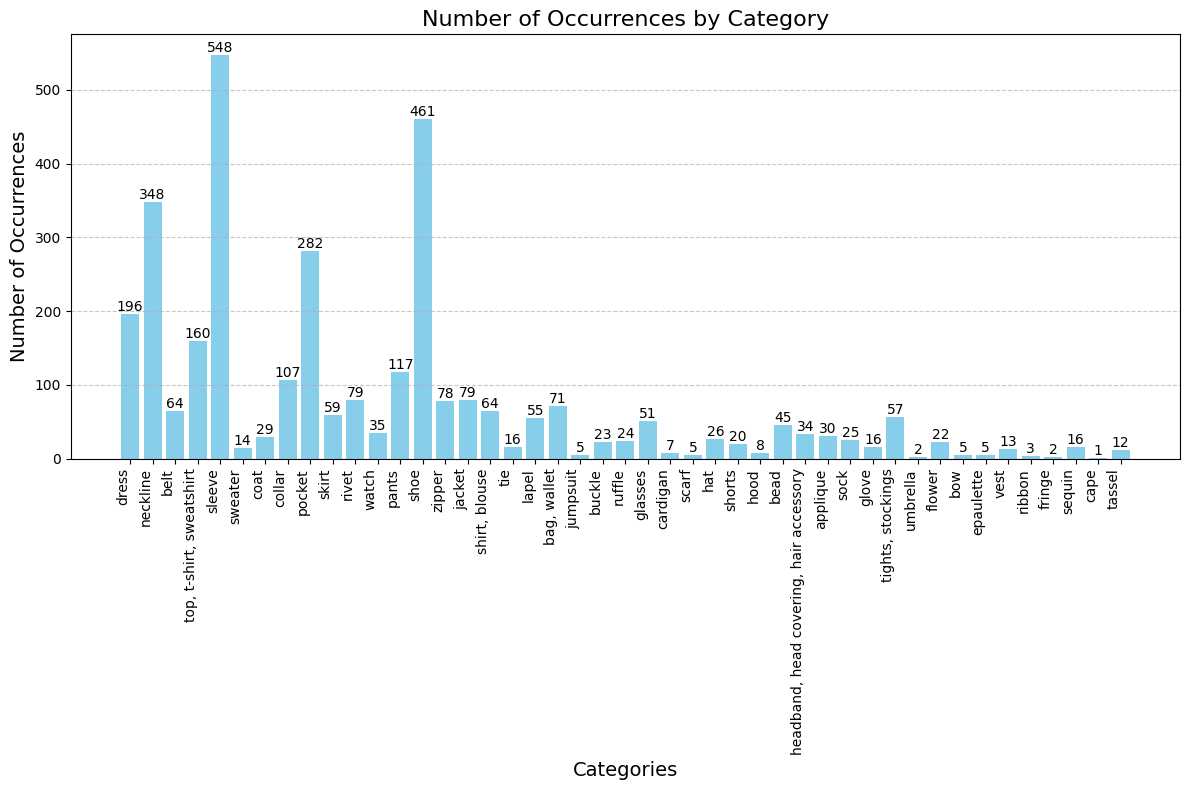

In [16]:
import matplotlib.pyplot as plt

categories = list(category_examples.keys())
values = list(category_examples.values())

fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.bar(categories, values, color="skyblue")

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Number of Occurrences", fontsize=14)
ax.set_title("Number of Occurrences by Category", fontsize=16)

ax.set_xticklabels(categories, rotation=90, ha="right")
ax.grid(axis="y", linestyle="--", alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

## data augmentation

![](https://albumentations.ai/docs/images/introduction/dedicated_library/pixel_and_spatial_level_augmentations_for_object_detection.jpg)

In [17]:
import albumentations as A

train_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.Rotate(limit=10, p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.GaussianBlur(p=0.5),
        A.GaussNoise(p=0.5),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"]),
)

val_transform = A.Compose(
    [
        A.LongestMaxSize(500),
        A.PadIfNeeded(500, 500, border_mode=0, value=(0, 0, 0)),
    ],
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=["category"]),
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


initial image processor

In [18]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50-dc5"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/274 [00:00<?, ?B/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [19]:
# apply
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

def convert_voc_to_coco(bbox):
    xmin, ymin, xmax, ymax = bbox
    width = xmax - xmin
    height = ymax - ymin
    return [xmin, ymin, width, height]

def transform_aug_ann(examples, transform):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])

        # Convert to COCO format
        converted_bboxes = [convert_voc_to_coco(bbox) for bbox in out["bboxes"]]
        bboxes.append(converted_bboxes)

        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def transform_train(examples):
    return transform_aug_ann(examples, transform=train_transform)

def transform_val(examples):
    return transform_aug_ann(examples, transform=val_transform)

train_dataset_transformed = train_dataset.with_transform(transform_train)
test_dataset_transformed = test_dataset.with_transform(transform_val)

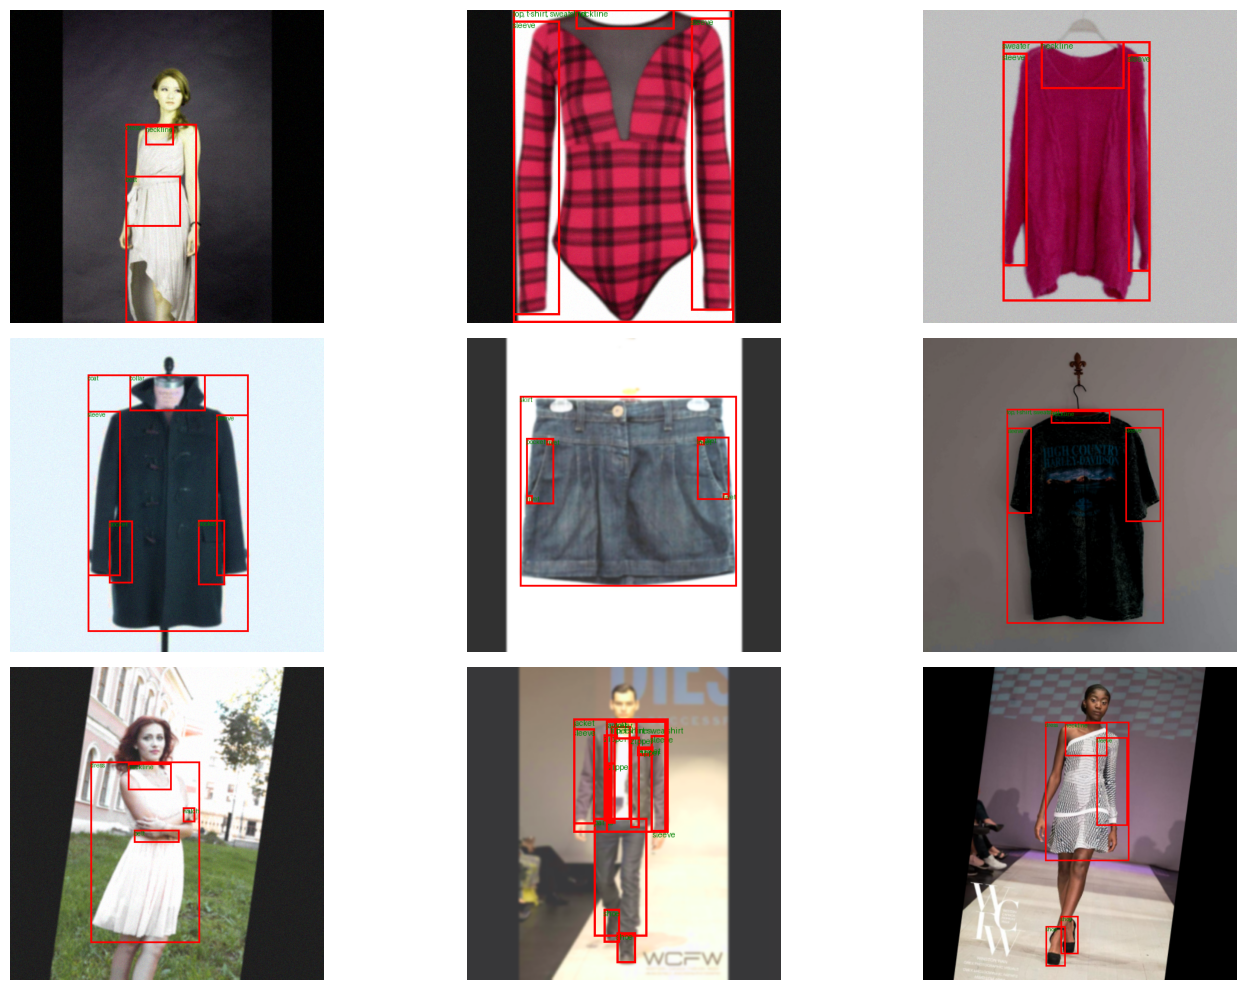

In [20]:
def draw_augmented_image_from_idx(dataset, idx, transform=None):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]

    image = np.array(image.convert("RGB"))[:, :, ::-1]

    if transform:
        augmented = transform(image=image, bboxes=annotations["bbox"], category=annotations["category"])
        image = augmented["image"]
        annotations["bbox"] = augmented["bboxes"]
        annotations["category"] = augmented["category"]

    image = Image.fromarray(image[:, :, ::-1])  # convert back to PIL
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["bbox_id"])):
        box = annotations["bbox"][i]
        x1, y1, x2, y2 = tuple(box)

        # normalize if necessary
        if max(box) <= 1.0:
            x1, y1 = int(x1 * width), int(y1 * height)
            x2, y2 = int(x2 * width), int(y2 * height)
        else:
            x1, y1 = int(x1), int(y1)
            x2, y2 = int(x2), int(y2)

        draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
        draw.text((x1, y1), id2label[annotations["category"][i]], fill="green")

    return image


def plot_augmented_images(dataset, indices, transform=None):
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        image = draw_augmented_image_from_idx(dataset, idx, transform=transform)

        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


plot_augmented_images(train_dataset, range(9), transform=train_transform)

init model from checkpoint

In [21]:
from transformers import AutoModelForObjectDetection
import os

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

os.mkdir("./output")
output_dir = "./output"

config.json:   0%|          | 0.00/4.38k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model check

fine tune

In [22]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.nn.functional import softmax


def denormalize_boxes(boxes, width, height):
    boxes = boxes.clone()
    boxes[:, 0] *= width  # xmin
    boxes[:, 1] *= height  # ymin
    boxes[:, 2] *= width  # xmax
    boxes[:, 3] *= height  # ymax
    return boxes


batch_metrics = []


def compute_metrics(eval_pred, compute_result):
    global batch_metrics

    (loss_dict, scores, pred_boxes, last_hidden_state, encoder_last_hidden_state), labels = eval_pred

    image_sizes = []
    target = []
    for label in labels:

        image_sizes.append(label["orig_size"])
        width, height = label["orig_size"]
        denormalized_boxes = denormalize_boxes(label["boxes"], width, height)
        target.append(
            {
                "boxes": denormalized_boxes,
                "labels": label["class_labels"],
            }
        )
    predictions = []
    for score, box, target_sizes in zip(scores, pred_boxes, image_sizes):
        # Extract the bounding boxes, labels, and scores from the model's output
        pred_scores = score[:, :-1]  # Exclude the no-object class
        pred_scores = softmax(pred_scores, dim=-1)
        width, height = target_sizes
        pred_boxes = denormalize_boxes(box, width, height)
        pred_labels = torch.argmax(pred_scores, dim=-1)

        # Get the scores corresponding to the predicted labels
        pred_scores_for_labels = torch.gather(pred_scores, 1, pred_labels.unsqueeze(-1)).squeeze(-1)
        predictions.append(
            {
                "boxes": pred_boxes,
                "scores": pred_scores_for_labels,
                "labels": pred_labels,
            }
        )

    metric = MeanAveragePrecision(box_format="xywh", class_metrics=True)

    if not compute_result:
        # Accumulate batch-level metrics
        batch_metrics.append({"preds": predictions, "target": target})
        return {}
    else:
        # Compute final aggregated metrics
        # Aggregate batch-level metrics (this should be done based on your metric library's needs)
        all_preds = []
        all_targets = []
        for batch in batch_metrics:
            all_preds.extend(batch["preds"])
            all_targets.extend(batch["target"])

        # Update metric with all accumulated predictions and targets
        metric.update(preds=all_preds, target=all_targets)
        metrics = metric.compute()

        # Convert and format metrics as needed
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")

        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        # Round metrics for cleaner output
        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        # Clear batch metrics for next evaluation
        batch_metrics = []

        return metrics

In [23]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]

    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels

    return batch

In [ ]:
from transformers import TrainingArguments, Trainer
import wandb

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=10000,
    fp16=True,
    save_steps=10,
    logging_steps=1,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    evaluation_strategy="steps",
    eval_steps=50,
    eval_strategy="steps",
    report_to="wandb",
    push_to_hub=True,
    batch_eval_metrics=True,
)

wandb.init(
    project="detr-fashionpedia-finetuned",
    name="detr-fashionpedia-finetuned",
    config=training_args,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


max_steps is given, it will override any value given in num_train_epochs
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss


# CRASHED DUE TO LESS VRAM

going to just let it now, so i can just check the code

In [ ]:
trainer.push_to_hub()

## test



In [ ]:
import requests
from transformers import pipeline
import numpy as np
from PIL import Image, ImageDraw

url = "https://images.unsplash.com/photo-1536243298747-ea8874136d64?q=80&w=640"
image = Image.open(requests.get(url, stream=True).raw)

obj_detector = pipeline(
    "object-detection", model="sergiopaniego/detr-resnet-50-dc5-fashionpedia-finetuned"  # Change with your model name
)

results = obj_detector(image)
print(results)

In [ ]:
from PIL import Image, ImageDraw
import numpy as np

def plot_results(image, results, threshold=0.6):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    width, height = image.size

    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())

        if score > threshold:
            x1, y1, x2, y2 = tuple(box)
            draw.rectangle((x1, y1, x2, y2), outline="red", width=3)
            draw.text((x1 + 5, y1 - 10), label, fill="white")
            draw.text((x1 + 5, y1 + 10), f"{score:.2f}", fill="green" if score > 0.7 else "red")

    return image

plot_results(image, results)

In [ ]:
metrics = trainer.evaluate(test_dataset_transformed)
print(metrics)